# **Siamese**

In [2]:
import sys
sys.path.append('../')

import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap

import torch

DATA_PATH = '../data/'
MAXAR_REVIEWED_PATH = DATA_PATH + 'maxar_reviewed_patches/'
SIAMESE_PATH = DATA_PATH + 'models/siamese.pth'

from src.siamese.siamese_train import get_model, get_dataloaders

BATCH_SIZE = 1
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

Image.MAX_IMAGE_PIXELS = 303038464

In [26]:
siamese = get_model()
siamese.load_state_dict(torch.load(SIAMESE_PATH))

train_dataloader, test_dataloader, _ = get_dataloaders(data_path=DATA_PATH, batch_size=BATCH_SIZE)

✅ Train dataloader length: 338
✅ Test dataloader length: 72
✅ Val dataloader length: 74


In [27]:
it = iter(train_dataloader)

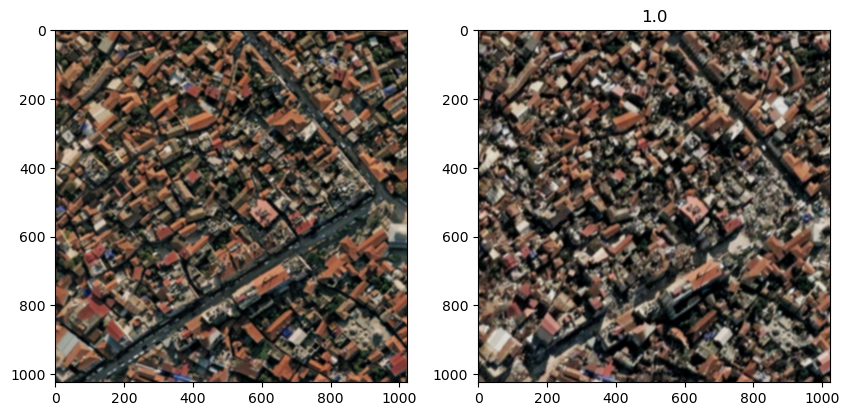

In [46]:
# Show
pre, post, label = next(it)
pre = pre[0].permute(1, 2, 0).numpy()
post = post[0].permute(1, 2, 0).numpy()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(pre)
plt.subplot(1, 2, 2)
plt.imshow(post)
plt.title(label[0].item())
plt.show()

In [156]:
siamese.eval()
embeddings = []
label_type = []
class_type = []

with torch.no_grad():
    for pre, post, label in tqdm(test_dataloader):
        # Move the data to the device
        pre, post = pre.to(DEVICE), post.to(DEVICE)

        # Forward pass
        pre_embeddings, post_embeddings = siamese(pre, post)

        embeddings.append(pre_embeddings.squeeze(0).cpu().numpy())
        class_type.append(label.numpy().item())

        embeddings.append(post_embeddings.squeeze(0).cpu().numpy())
        class_type.append(label.numpy().item())

embeddings = np.array(embeddings)
label_type = np.array(label_type)
class_type = np.array(class_type)

100%|██████████| 72/72 [00:09<00:00,  7.62it/s]


In [157]:
# Print mean distance between intact pairs
intact_distances = []
damaged_distances = []
for i in range(0, len(embeddings), 2):
    pre_point = embeddings[i]
    post_point = embeddings[i + 1]

    if class_type[i] == 0:
        intact_distances.append(np.linalg.norm(pre_point - post_point))
    else:
        damaged_distances.append(np.linalg.norm(pre_point - post_point))

print('Mean distance between intact pairs:', np.mean(intact_distances))
print('Mean distance between damaged pairs:', np.mean(damaged_distances))

Mean distance between intact pairs: 0.7558904
Mean distance between damaged pairs: 0.7551252


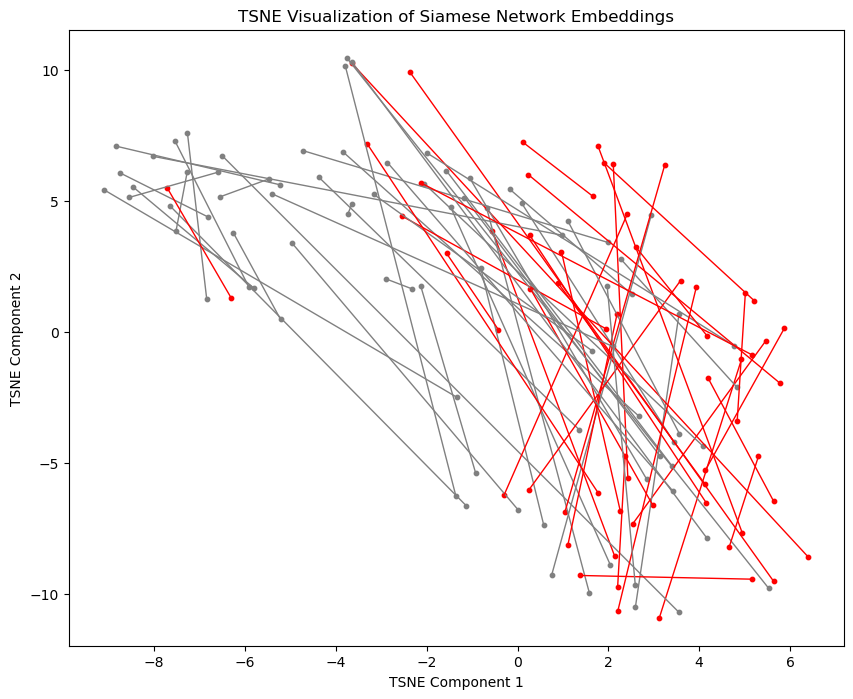

In [158]:
# Use TSNE to reduce the dimensionality for visualization
tsne = TSNE(n_components=2, random_state=0)
Y = tsne.fit_transform(embeddings)

# Plotting
plt.figure(figsize=(10, 8))

# Iterate over each pair of points
for i in range(0, len(Y), 2):
    pre_point = Y[i]
    post_point = Y[i + 1]
    class_label = class_type[i]

    # Determine the color based on class type
    color = 'red' if class_label != 0 else 'gray'

    # Plotting the points
    plt.scatter([pre_point[0], post_point[0]], [pre_point[1], post_point[1]], color=color, s=10)

    # Drawing a line between each pair
    plt.plot([pre_point[0], post_point[0]], [pre_point[1], post_point[1]], color=color, linewidth=1)

# Adding labels and title
plt.title('TSNE Visualization of Siamese Network Embeddings')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.show()

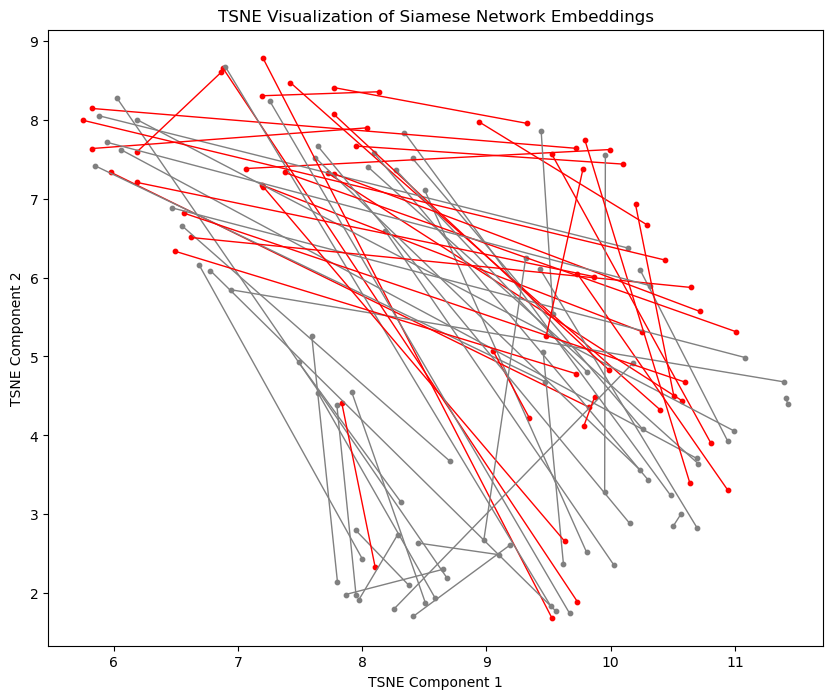

In [159]:
# Use TSNE to reduce the dimensionality for visualization
reducer = umap.UMAP()
Y = reducer.fit_transform(embeddings)

# Plotting
plt.figure(figsize=(10, 8))

# Iterate over each pair of points
for i in range(0, len(Y), 2):
    pre_point = Y[i]
    post_point = Y[i + 1]
    class_label = class_type[i]

    # Determine the color based on class type
    color = 'red' if class_label != 0 else 'gray'

    # Plotting the points
    plt.scatter([pre_point[0], post_point[0]], [pre_point[1], post_point[1]], color=color, s=10)

    # Drawing a line between each pair
    plt.plot([pre_point[0], post_point[0]], [pre_point[1], post_point[1]], color=color, linewidth=1)

# Adding labels and title
plt.title('TSNE Visualization of Siamese Network Embeddings')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.show()